# Проект: классификация

In [744]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
import optuna

#### Данные о клиентах банка:
- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

#### Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:
- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

#### Прочие признаки:
- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

#### Целевая переменная 
- deposit, которая определяет, согласится ли клиент открыть депозит в банке

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

Исследуем пропущенные значения

In [745]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [746]:
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [747]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [748]:
# список столбцов с пропусками
cols_null_percent = df.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
cols_with_null

balance    0.223974
dtype: float64

In [749]:
df['balance'].isnull().sum()

25

### Задание 2

Найдем каким словом и в каких столбцах закодированы пропуски (неизвестные значения)

In [750]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [751]:
df['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [752]:
df['contact'].value_counts()

cellular     8042
unknown      2346
telephone     774
Name: contact, dtype: int64

In [753]:
df['poutcome'].value_counts()

unknown    8326
failure    1228
success    1071
other       537
Name: poutcome, dtype: int64

### Задание 3

Вычислим среднее значение по преобразованному в корректный вид признаку balance. Ответ округлим до трёх знаков после точки-разделителя.

In [754]:
# преобразуем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].str.replace("[ $]", "", regex=True)
df['balance'] = df['balance'].str.replace("[,]", ".", regex=True)
df['balance'] = df['balance'].astype('float64')
df['balance']

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

Вычислим среднее значение по преобразованному в корректный вид признаку balance

In [755]:
round(df['balance'].mean(), 3)

1529.129

### Задание 4

Обработаем пропуски в признаке balance, заменив их на медианные значения по данному признаку. Вычислим среднее, ответ округлим до трёх знаков после точки-разделителя.

In [756]:
df['balance'] = df['balance'].fillna(df['balance'].median())

Вычислим среднее значение по преобразованному в корректный вид признаку balance

In [757]:
round(df['balance'].mean(), 3)

1526.936

### Задание 5

Заменим все пропущенные значения в признаке job на модальные. То же самое сделаем с признаком, отвечающим за уровень образования. После замены пропусков рассчитаем средний доход для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). Ответ округлим до трёх знаков после точки-разделителя.

In [758]:
# df.loc[df.job == 'unknown', 'job'] = 'management'
# df.loc[df.education == 'unknown', 'education'] = 'secondary'
# df[(df.job == 'management')&(df.education == 'secondary')]['balance'].mean()

In [759]:
job_mode = df['job'].mode()
education_mode = df['education'].mode()

df = df.replace({
    'job': {
        'unknown': job_mode
    },
    'education': {
        'unknown': education_mode
    }
})

После замены пропусков рассчитам средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование).

In [760]:
mask1 = df['job']==job_mode.loc[0]
mask2 = df['education']==education_mode.loc[0]
round(df[mask1 & mask2]['balance'].mean(), 3)

1598.883

### Задание 6

Изучим признак, отображающий доход клиентов, на предмет выбросов. Удалим все выбросы, воспользовавшись методом Тьюки.

In [761]:
df.describe(include=['float64'])

,balance
count,11162.000000
mean,1526.936033
std,3224.829691
min,-6847.000000
25%,123.000000
50%,550.000000
75%,1699.000000
max,81204.000000


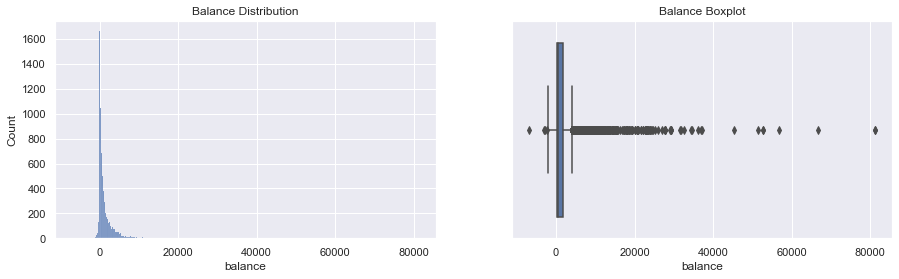

In [762]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Balance Distribution');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('Balance Boxplot');

In [763]:
# def outliers_iqr(data, feature):
#     x = data[feature]
#     quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
#     iqr = quartile_3 - quartile_1
#     lower_bound = quartile_1 - (iqr * 1.5)
#     upper_bound = quartile_3 + (iqr * 1.5)
#     outliers = data[(x<lower_bound) | (x > upper_bound)]
#     cleaned = data[(x>lower_bound) & (x < upper_bound)]
#     return outliers, cleaned

# outliers, cleaned = outliers_iqr(df, 'balance')
# print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
# print(f'Результирующее число записей: {cleaned.shape[0]}')

In [764]:
Q1 = np.percentile(df['balance'], 25,
                   interpolation = 'midpoint')

Q3 = np.percentile(df['balance'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR

cleaned = df[(df['balance']>=lower)&(df['balance']<=upper)]
cleaned.shape

(10105, 17)

## Часть 2:  Разведывательный анализ

### Задание 1

Изучим соотношение классов в данных на предмет несбалансированности, проиллюстрируем результат

In [765]:
cleaned['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

Text(0.5, 1.0, 'Соотношение классов')

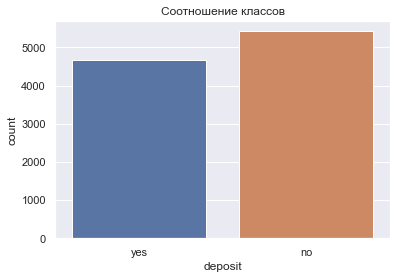

In [766]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="deposit", data=cleaned)
ax.set_title('Соотношение классов')

Соотношение классов примерно на одном уровне.

### Задание 2

Рассчитаем описательные статистики для количественных переменных, проинтерпретируем результат

In [767]:
cleaned_num = cleaned.select_dtypes(include=['int64', 'float64'])
cleaned_num.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'balance'}>,
        <AxesSubplot:title={'center':'day'}>],
       [<AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'campaign'}>,
        <AxesSubplot:title={'center':'pdays'}>],
       [<AxesSubplot:title={'center':'previous'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

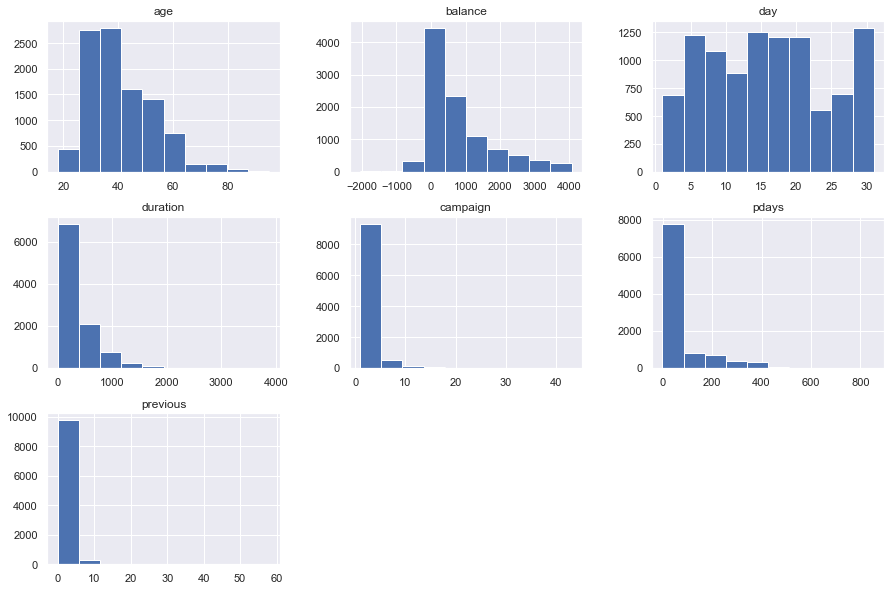

In [768]:
cleaned_num.hist(figsize=(15, 10))

### Задание 3

Рассчитаем описательные статистики для категориальных переменных, проинтерпретируем результат

In [769]:
cleaned_cat = cleaned.select_dtypes(include=['object'])

In [770]:
cleaned_cat.describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Text(0.5, 1.0, 'Job')

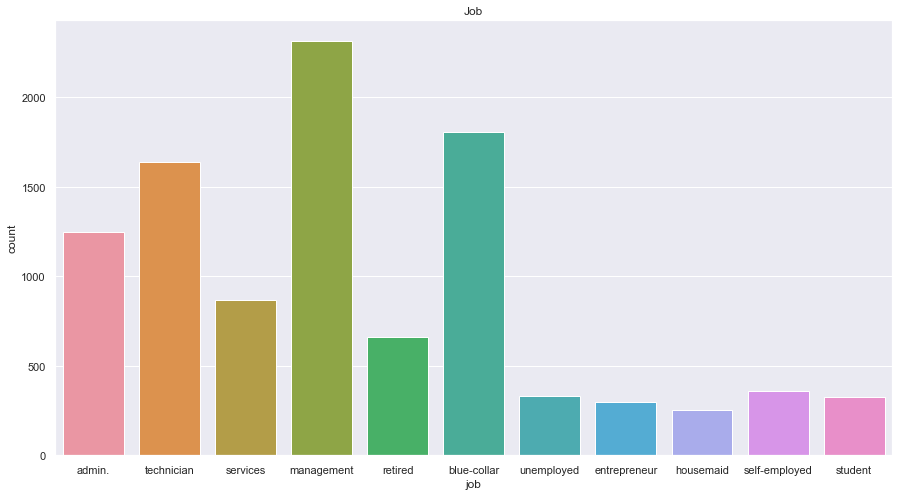

In [771]:
plt.figure(figsize=(15,8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="job", data=cleaned_cat)
ax.set_title('Job')

Text(0.5, 1.0, 'Month')

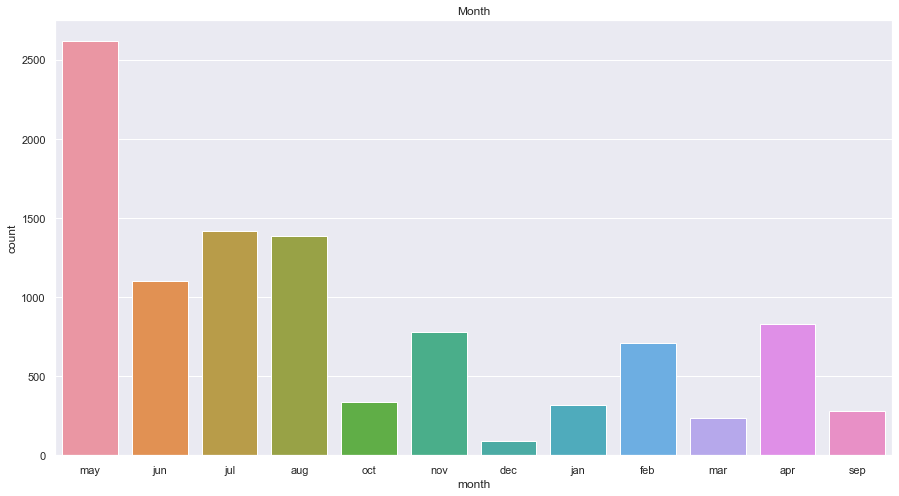

In [772]:
plt.figure(figsize=(15,8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="month", data=cleaned_cat)
ax.set_title('Month')

[[Text(0.0, 0, ''),
  Text(2000.0, 0, ''),
  Text(4000.0, 0, ''),
  Text(6000.0, 0, ''),
  Text(8000.0, 0, ''),
  Text(10000.0, 0, '')]]

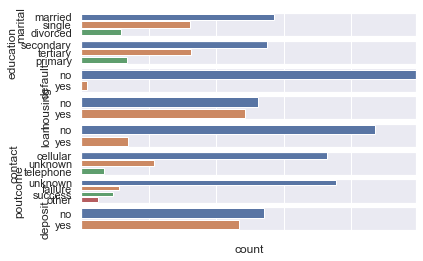

In [773]:
sns.set(style="darkgrid")
fig, ax =plt.subplots(8,1)
max_count = max([max(cleaned_cat[i].value_counts()) for i in cleaned_cat.columns])
marital=sns.countplot(y=cleaned_cat['marital'],ax=ax[0],order=df.marital.value_counts().index)
education=sns.countplot(y=cleaned_cat['education'],ax=ax[1],order=df.education.value_counts().index)
default=sns.countplot(y=cleaned_cat['default'],ax=ax[2],order=df.default.value_counts().index)
housing=sns.countplot(y=cleaned_cat['housing'],ax=ax[3],order=df.housing.value_counts().index)
loan=sns.countplot(y=cleaned_cat['loan'],ax=ax[4],order=df.loan.value_counts().index)
contact=sns.countplot(y=cleaned_cat['contact'],ax=ax[5],order=df.contact.value_counts().index)
poutcome=sns.countplot(y=cleaned_cat['poutcome'],ax=ax[6],order=df.poutcome.value_counts().index)
deposit=sns.countplot(y=cleaned_cat['deposit'],ax=ax[7],order=df.deposit.value_counts().index)
ax[0].set_xlim(0,max_count)
ax[1].set_xlim(0,max_count)
ax[2].set_xlim(0,max_count)
ax[3].set_xlim(0,max_count)
ax[4].set_xlim(0,max_count)
ax[5].set_xlim(0,max_count)
ax[6].set_xlim(0,max_count)
ax[7].set_xlim(0,max_count)
marital.set(xticklabels=[])
education.set(xticklabels=[])
default.set(xticklabels=[])
housing.set(xticklabels=[])
loan.set(xticklabels=[])
contact.set(xticklabels=[])
poutcome.set(xticklabels=[])
deposit.set(xticklabels=[])

### Задание 4

Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

<AxesSubplot:xlabel='poutcome'>

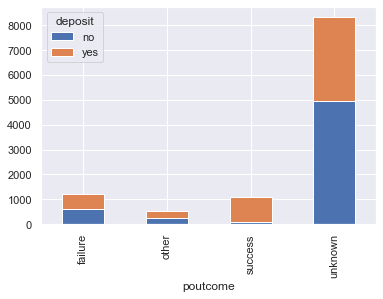

In [774]:
types = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')


### Задание 5

Узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит

In [775]:
# Список месяцев в датасете
months_list = list(cleaned['month'].value_counts().index)
# Количество отказов по месяцам
count_no = cleaned.groupby(by='month')['deposit'].value_counts()
# Количество контактов по месяцам
count_campaign = cleaned.groupby(by='month')['campaign'].count()
# Формируем словарь с процентами неудач при взаимодействии в текущей маркетинговой кампании
answer = dict()
for month in months_list:
    answer[month] = round(count_no[month]['no'] / count_campaign[month] * 100, 2)

sorted_answer = dict(sorted(answer.items(), key=lambda item: item[1]))
sorted_answer

{'dec': 9.68,
 'mar': 10.13,
 'sep': 16.55,
 'oct': 18.51,
 'apr': 38.19,
 'feb': 45.56,
 'jun': 54.89,
 'aug': 55.96,
 'nov': 58.46,
 'jul': 58.96,
 'jan': 60.82,
 'may': 67.86}

### Задание 6

Создадим возрастные группы и определим, в каких группах более склонны открывать депозит, чем отказываться от предложения

In [776]:
cleaned['age_group'] = cleaned.apply(
    lambda x: '<30' if x['age'] < 30 else (
              '30-40' if 30 <= x['age'] <40 else (
              '40-50' if 40 <= x['age'] <50 else (
              '50-60' if 50 <= x['age'] <60 else 
              '60+'))), 
    axis=1)

In [777]:
age_groups = cleaned.groupby(by='age_group')['deposit'].value_counts(normalize=True).unstack()
age_groups

deposit,no,yes
age_group,,
30-40,0.566776,0.433224
40-50,0.606213,0.393787
50-60,0.594921,0.405079
60+,0.240429,0.759571
<30,0.408247,0.591753


<AxesSubplot:xlabel='age_group'>

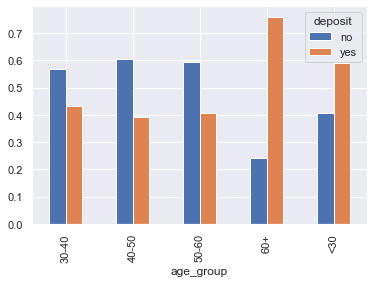

In [778]:
age_groups.plot.bar()

### Задание 7

Построим визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

In [779]:
marital_groups = cleaned.groupby(by='marital')['deposit'].value_counts(normalize=False).unstack()
marital_groups

deposit,no,yes
marital,,
divorced,624,553
married,3303,2412
single,1497,1716


<AxesSubplot:xlabel='marital'>

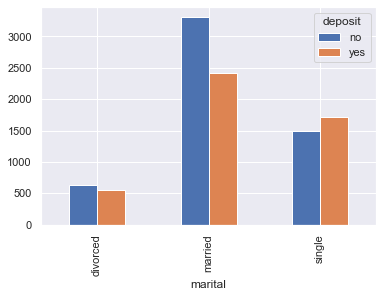

In [780]:
marital_groups.plot.bar()

Построим визуализации для открывших и неоткрывших депозит в зависимости от образования

In [781]:
education_groups = cleaned.groupby(by='education')['deposit'].value_counts(normalize=False).unstack()
education_groups

deposit,no,yes
education,,
primary,832,517
secondary,3066,2451
tertiary,1526,1713


<AxesSubplot:xlabel='education'>

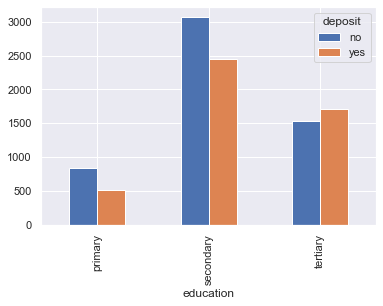

In [782]:
education_groups.plot.bar()

Построим визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

In [783]:
job_groups = cleaned.groupby(by='job')['deposit'].value_counts(normalize=False).unstack()
job_groups

deposit,no,yes
job,,
admin.,672,574
blue-collar,1155,652
entrepreneur,189,111
housemaid,153,99
management,1180,1135
retired,231,432
self-employed,197,161
services,523,345
student,81,245


<AxesSubplot:xlabel='job'>

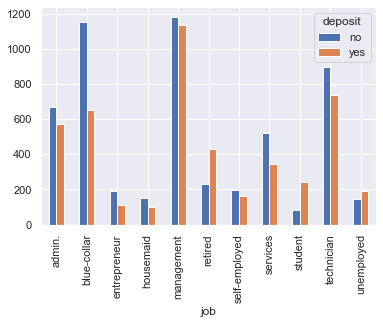

In [784]:
job_groups.plot.bar()

### Задание 8

Построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны, если рассматривать тех, кто открыл депозит.

In [785]:
deposit_yes = cleaned[cleaned['deposit'] == 'yes']
education_marital_groups = deposit_yes.groupby(by=['education', 'marital'])['deposit'].value_counts(normalize=False).unstack()
education_marital_groups

deposit              yes
education marital       
primary   divorced    96
          married    339
          single      82
secondary divorced   283
          married   1289
          single     879
tertiary  divorced   174
          married    784
          single     755

<AxesSubplot:xlabel='education,marital'>

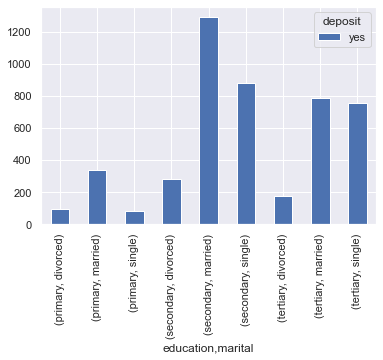

In [786]:
education_marital_groups.plot.bar()

## Часть 3: преобразование данных

### Задание 1

Преобразуем уровни образования

In [787]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
cleaned['education'] = labelencoder.fit_transform(cleaned['education'])

#cleaned['education'] = cleaned['education'].map({'primary': 1, 'secondary': 2, 'tertiary': 3})

Найдем сумму получившихся значений для признака education

In [788]:
cleaned['education'].sum()

11995

Преобразуем категории возраста

In [789]:
cleaned['age_group'] = labelencoder.fit_transform(cleaned['age_group'])

### Задание 2

Преобразуем бинарные переменные в представление из нулей и единиц

In [790]:
cleaned['default'] = cleaned['default'].map({'yes': 1,'no': 0}) 
cleaned['housing'] = cleaned['housing'].map({'yes': 1,'no': 0}) 
cleaned['loan'] = cleaned['loan'].map( {'yes': 1,'no': 0}) 
cleaned['deposit'] = cleaned['deposit'].map({'yes': 1,'no': 0}) 

In [791]:
print(cleaned['default'].mean()+cleaned['housing'].mean()+cleaned['loan'].mean())

0.6354280059376547


### Задание 3

Преобразуем номинальные переменные, которые могут принимать несколько различных значений.

In [792]:
categorial_features = ['job', 'marital', 'contact', 'month', 'poutcome']
cleaned1= pd.get_dummies(cleaned[categorial_features])
cleaned = df = pd.concat([cleaned,cleaned1], axis = 1)

In [793]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 51 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   job                10105 non-null  object 
 2   marital            10105 non-null  object 
 3   education          10105 non-null  int32  
 4   default            10105 non-null  int64  
 5   balance            10105 non-null  float64
 6   housing            10105 non-null  int64  
 7   loan               10105 non-null  int64  
 8   contact            10105 non-null  object 
 9   day                10105 non-null  int64  
 10  month              10105 non-null  object 
 11  duration           10105 non-null  int64  
 12  campaign           10105 non-null  int64  
 13  pdays              10105 non-null  int64  
 14  previous           10105 non-null  int64  
 15  poutcome           10105 non-null  object 
 16  deposit            101

### Задание 4

Построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности

In [794]:
cleaned.corr()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
age,1.000000,-0.191124,-0.009929,0.115164,-0.164196,-0.026357,0.000396,-0.006007,-0.001143,0.006107,...,0.009769,0.024785,-0.119656,0.026875,0.056998,0.036352,0.001994,-0.020942,0.060009,-0.031455
education,-0.191124,1.000000,-0.015692,0.043251,-0.094350,-0.052566,0.008989,-0.016869,-0.012280,0.024123,...,-0.036503,0.052196,-0.104157,0.028704,0.027617,0.030846,0.019845,0.015103,0.070489,-0.069069
default,-0.009929,-0.015692,1.000000,-0.110928,0.009551,0.074786,0.018724,-0.008162,0.033404,-0.037323,...,0.019626,-0.020028,-0.001761,0.000544,-0.023931,-0.016977,-0.025450,-0.017923,-0.041510,0.055032
balance,0.115164,0.043251,-0.110928,1.000000,-0.094919,-0.113089,-0.009987,0.025781,-0.042689,0.045155,...,0.039753,0.043832,-0.098073,0.081861,0.057041,0.047841,0.031040,0.028111,0.073358,-0.085456
housing,-0.164196,-0.094350,0.009551,-0.094919,1.000000,0.072252,-0.022644,0.038492,0.006257,0.064138,...,-0.073133,-0.075948,0.432605,-0.000219,-0.092026,-0.086893,0.085167,0.009830,-0.134477,0.024082
loan,-0.026357,-0.052566,0.074786,-0.113089,0.072252,1.000000,0.019136,0.001476,0.033889,-0.030788,...,-0.014897,-0.041105,0.002778,0.017720,-0.032357,-0.046196,0.007458,-0.019289,-0.082098,0.059235
day,0.000396,0.008989,0.018724,-0.009987,-0.022644,0.019136,1.000000,-0.016695,0.142169,-0.078757,...,-0.182032,-0.044303,-0.014580,0.056471,0.072179,-0.068744,-0.071175,-0.008806,-0.044366,0.085442
duration,-0.006007,-0.016869,-0.008162,0.025781,0.038492,0.001476,-0.016695,1.000000,-0.042576,-0.033053,...,-0.003061,-0.034640,0.007983,-0.015655,-0.012541,-0.012077,-0.039476,-0.009497,-0.025971,0.050571
campaign,-0.001143,-0.012280,0.033404,-0.042689,0.006257,0.033889,0.142169,-0.042576,1.000000,-0.105214,...,0.046763,-0.030574,-0.044348,-0.077307,-0.071519,-0.048672,-0.082282,-0.024854,-0.094260,0.134842
pdays,0.006107,0.024123,-0.037323,0.045155,0.064138,-0.030788,-0.078757,-0.033053,-0.105214,1.000000,...,-0.093551,0.024192,0.028678,-0.007350,0.079833,0.110907,0.608719,0.338049,0.326215,-0.824031


Дополним матрицу корелляций тепловой картой

<AxesSubplot:>

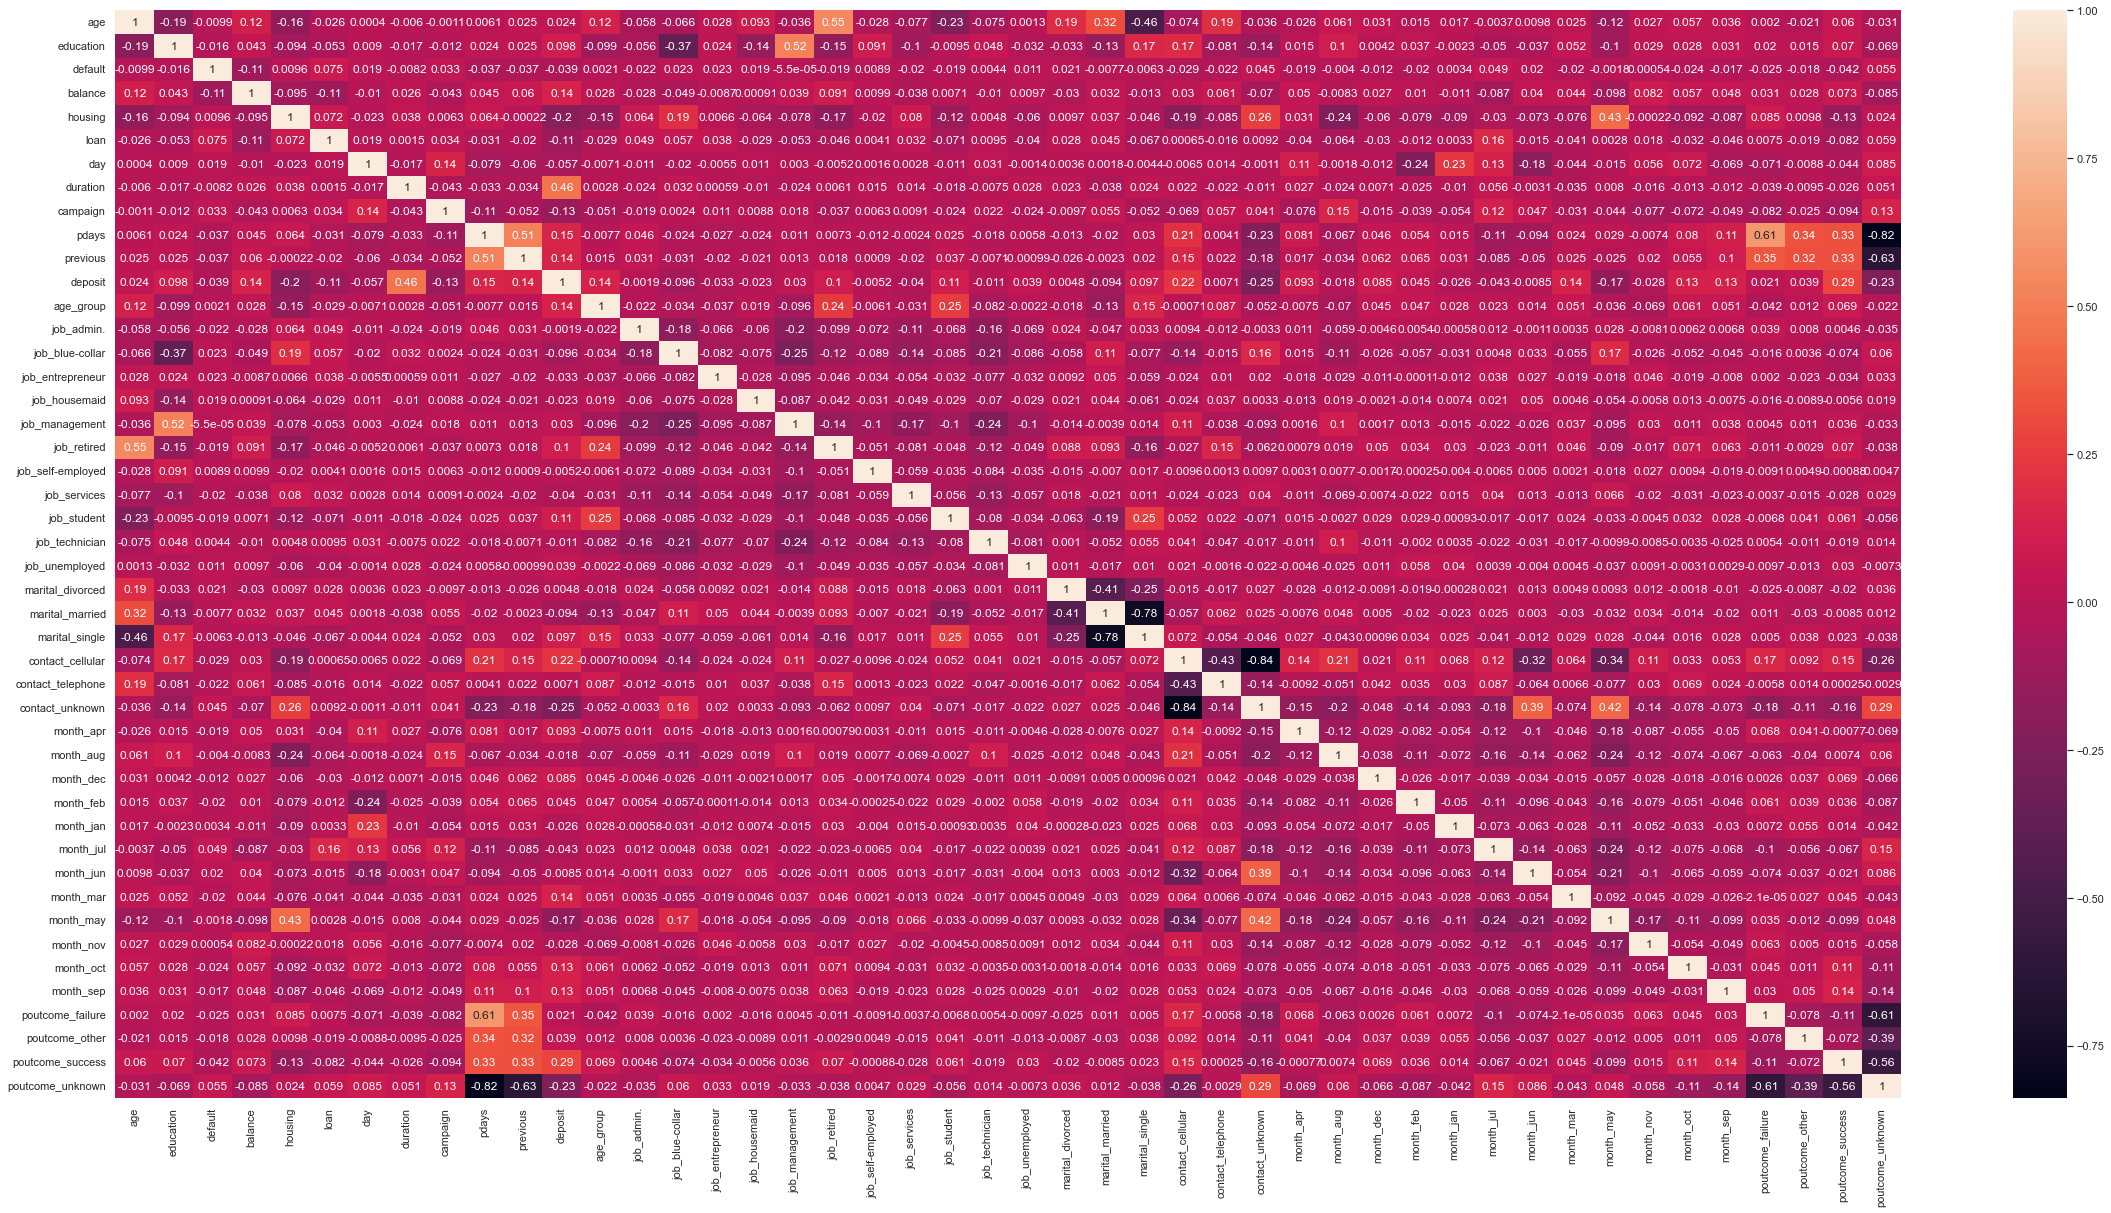

In [795]:
plt.figure(figsize=(40,20))
sns.heatmap(cleaned.corr(), annot = True)

Сильной мультиколлениартности (выше 0,9) не имеем.

### Задание 5

Необходимо определить целевую переменную и предикторы, а также разделить выборку на обучающую и тестовую.

In [796]:
#удалим все колонки со значениями кроме числовых
cleaned = cleaned.select_dtypes(exclude='object')

In [797]:
X = cleaned.drop(['deposit'], axis=1)
y = cleaned['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [798]:
# размер тестовой выборки
X_test.shape

(3335, 45)

In [799]:
# среднее значение целевой переменной на тестовой выборке
y_test.mean()

0.46326836581709147

### Задание 6

С помощью SelectKBest отберите 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_classif.

In [800]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6770 entries, 7287 to 4966
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                6770 non-null   int64  
 1   education          6770 non-null   int32  
 2   default            6770 non-null   int64  
 3   balance            6770 non-null   float64
 4   housing            6770 non-null   int64  
 5   loan               6770 non-null   int64  
 6   day                6770 non-null   int64  
 7   duration           6770 non-null   int64  
 8   campaign           6770 non-null   int64  
 9   pdays              6770 non-null   int64  
 10  previous           6770 non-null   int64  
 11  age_group          6770 non-null   int32  
 12  job_admin.         6770 non-null   uint8  
 13  job_blue-collar    6770 non-null   uint8  
 14  job_entrepreneur   6770 non-null   uint8  
 15  job_housemaid      6770 non-null   uint8  
 16  job_management     67

In [801]:
# selector = SelectKBest(f_classif, k=15)
# selector.fit(X_train, y_train)
# selector.get_feature_names_out()

select_k_best_classifier = SelectKBest(score_func=f_classif, k=15).fit(X_train, y_train)
select_k_best_classifier.get_support()
feature_names = list(X_train.columns.values)
mask = select_k_best_classifier.get_support() #list of booleans
new_features = [] # The list of your K best features
 
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

In [802]:
print(new_features)

['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous', 'age_group', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']


### Задание 7

Нормализуем данные с помощью minmaxsxaler.

In [803]:
# оставим выделенные признаки
X_train = X_train[new_features]
X_test = X_test[new_features]

In [804]:
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_test_scaled = mm_scaler.transform(X_test)
X_train_scaled = mm_scaler.transform(X_train)

Рассчитаем среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки.

In [805]:
print(X_test_scaled[0].mean())

0.22195148753363583


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

Обучите логистическую регрессию и рассчитайте метрики качества

In [806]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



### Задание 2

Обучите решающие деревья, настройте максимальную глубину

In [807]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



Модель с данными параметрами переобучена. Переберем различные максимальные глубины деревьев и найдем глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения.

In [808]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    min_samples_leaf=5,
    max_depth=6,
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = dt.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      3634
           1       0.78      0.85      0.81      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.77      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 3

Подберите оптимальные параметры с помощью gridsearch

In [809]:
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth': [3,5,7]
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid
)  
%time grid_search_tree.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_tree.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

Wall time: 514 ms
f1_score на обучающем наборе: 0.82
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

Обучите на ваших данных случайный лес

In [810]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
    )

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print(metrics.classification_report(y_train, y_train_pred))
y_test_pred = rf.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3634
           1       0.46      1.00      0.63      3136

    accuracy                           0.46      6770
   macro avg       0.23      0.50      0.32      6770
weighted avg       0.21      0.46      0.29      6770

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 2

Используйте для классификации градиентный бустинг и сравните качество со случайным лесом

In [811]:
#Создаем объект класса градиентный бустинг
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
#Обучаем модель
gb.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = gb.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))
y_test_pred = gb.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 3

Объедините уже известные вам алгоритмы с помощью стекинга 

In [812]:
#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
    )),
    ('dt',  tree.DecisionTreeClassifier(
    criterion='entropy',
    min_samples_split=2,
    max_depth=7,
    random_state=42
    ))
]

#Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
    )
)
#Обучаем модель
reg.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = gb.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))
y_test_pred = gb.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

Оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

                  importance
feature                     
duration               0.502
poutcome_success       0.116
contact_unknown        0.074
balance                0.060
pdays                  0.056
housing                0.047
age_group              0.042
month_mar              0.026
month_oct              0.019
campaign               0.017
month_may              0.015
month_sep              0.013
previous               0.009
contact_cellular       0.005
poutcome_unknown       0.000


<AxesSubplot:xlabel='feature'>

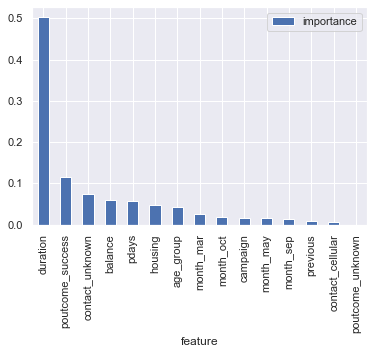

In [813]:
importances = pd.DataFrame({'feature': X_train.columns, 'importance': np.round(gb.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
print(importances)
importances.plot.bar()

### Задание 5

Реализуйте оптимизацию гиперпараметров с помощью Optuna

In [817]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=42)
    # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))

    return score


# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=30)


# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2022-06-01 20:08:55,240] A new study created in memory with name: RandomForestClassifier
[I 2022-06-01 20:08:55,714] Trial 0 finished with value: 0.8617886178861789 and parameters: {'n_estimators': 110, 'max_depth': 30, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8617886178861789.
[I 2022-06-01 20:08:56,329] Trial 1 finished with value: 0.8463713477851085 and parameters: {'n_estimators': 152, 'max_depth': 15, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8617886178861789.
[I 2022-06-01 20:08:57,217] Trial 2 finished with value: 0.8693341669271647 and parameters: {'n_estimators': 194, 'max_depth': 22, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8693341669271647.
[I 2022-06-01 20:08:58,021] Trial 3 finished with value: 0.8521358159912376 and parameters: {'n_estimators': 193, 'max_depth': 23, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.8693341669271647.
[I 2022-06-01 20:08:58,909] Trial 4 finished with value: 0.8694292415949962 and parameters: {'n

Наилучшие значения гиперпараметров {'n_estimators': 169, 'max_depth': 27, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.93
accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.82


График истории оптимизации

In [818]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

График важности гиперпараметров

In [819]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")